In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import pickle
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from scipy.spatial.distance import cdist

# 1.Pixel as feature on CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Here are the  10 random images from class:
![CIFAR-10 samples image](https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/cifar-10-samples.png)

In [ ]:
### CIFAR-10 dataset helper function ###

'''
data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
'''
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def cifar10Loader(setName='train', datasetDir='cifar-10-batches-py/'):
  cifarImages = []
  cifarLabels = []

  if setName == 'train':
    fileNamePrefix = 'data_batch_'
    for batchNo in range(1,6):
      batchData = unpickle(datasetDir + fileNamePrefix + str(batchNo))
      cifarImages.append(batchData[b'data'])
      cifarLabels.append(batchData[b'labels'])
    cifarImages = np.concatenate(cifarImages)
    cifarLabels = np.concatenate(cifarLabels)
    return cifarImages, cifarLabels

  else:
    batchData = unpickle(datasetDir + 'test_batch')
    return batchData[b'data'], batchData[b'labels']

def cifar10Labels(datasetDir='cifar-10-batches-py/'):
  byteLabels = unpickle(datasetDir + 'batches.meta')[b'label_names']
  return [label.decode("utf-8")  for label in byteLabels]

## 1.1 Download and Inspect CIFAR-10 dataset

In [ ]:
### Download and Extract CIFAR-10 Dataset ###
!wget -O cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xf cifar-10-python.tar.gz

--2024-11-16 05:27:49--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  14.0MB/s    in 13s     

2024-11-16 05:28:03 (12.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
cifarTrainImages, cifarTrainLabels = cifar10Loader(setName='train')
cifarTestImages, cifarTestLabels = cifar10Loader(setName='test')
cifarLabelNames = cifar10Labels()

cifarTrainImages = cifarTrainImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)
cifarTestImages = cifarTestImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)
totalTrainImages = len(cifarTrainLabels)
totalTestImages = len(cifarTestLabels)

print('Total train images :', totalTrainImages)
print('Total test images :', totalTestImages)
print('Labels :',cifarLabelNames)
print('cifarTrainImages shape :', cifarTrainImages.shape)
print('cifarTestImages shape :', cifarTestImages.shape)

Total train images : 50000
Total test images : 10000
Labels : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarTrainImages shape : (50000, 32, 32, 3)
cifarTestImages shape : (10000, 32, 32, 3)


['cat', 'deer', 'bird', 'automobile', 'deer', 'airplane', 'bird', 'ship']


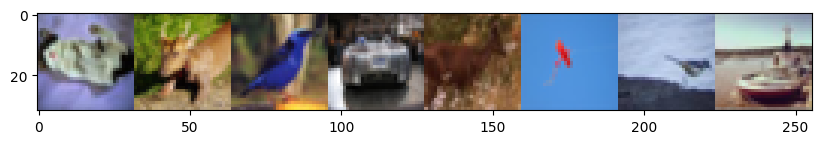

In [ ]:
### Randomly show train images and their labels ###
randTrainIdx = random.sample(range(0, totalTrainImages), 8)
sampleTrainImages = np.concatenate([cifarTrainImages[idx, :] for idx in randTrainIdx],axis=1)

plt.figure(figsize=(10,10))
plt.imshow(sampleTrainImages, interpolation='nearest')
print([ cifarLabelNames[labelIdx] for labelIdx in cifarTrainLabels[randTrainIdx]])

## 1.2 CIFAR-10 classification using nearest neighbour


Sample image real label => ship  Nearest label in train set => dog


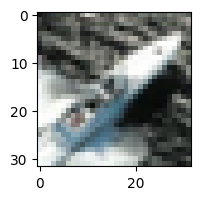

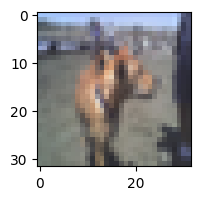

In [ ]:
### Randomly pick a image from test set ###
randTestIdx = random.randint(0, totalTestImages)
sampleTestImages = cifarTestImages[randTestIdx, :]

plt.figure(figsize=(2,2))
plt.imshow(sampleTestImages, interpolation='nearest')

### Find a nearest image from train set using euclidean distance ###
distance = ((sampleTestImages - cifarTrainImages)**2).reshape(totalTrainImages,-1)
distance = np.sqrt(np.sum(distance,axis=1))
minDistance = np.min(distance)
minIdx = np.argmin(distance)

nearestTrainImage = cifarTrainImages[minIdx, :]

plt.figure(figsize=(2,2))
plt.imshow(nearestTrainImage, interpolation='nearest')
print('Sample image real label =>', cifarLabelNames[cifarTestLabels[randTestIdx]],' Nearest label in train set =>', cifarLabelNames[cifarTrainLabels[minIdx]])

#### The output result will be very bad ==> pixel as feature is not enough ###

# 2.Convolutional Neural Networks Building Block
![alt text](http://cs231n.github.io/assets/cnn/convnet.jpeg)
Image from CS231n Convolutional Neural Networks for Visual Recognition [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

## 2.1 Convolution Layer

In [ ]:
%%html
<iframe src="https://cs231n.github.io/assets/conv-demo/index.html" width="800" height="700"></iframe>

## 2.2 Pooling Layer
<br>
<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="36%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="59%">

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

## 2.3 Get familiar with PyTorch layers

In [ ]:
### Convolution & MaxPool operators in PyTorch ###
sampleInput = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]],dtype=torch.float32)
print(sampleInput)

print('=== Convolution ===')
kernel = torch.tensor([[[[1,1],[1,1]]]], dtype=torch.float32)
convOutput = F.conv2d(sampleInput, kernel, padding=0)
print(convOutput, convOutput.shape)

print('=== Maxpool ===')
maxPoolOutput = F.max_pool2d(sampleInput, kernel_size=2)
print(maxPoolOutput)

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
=== Convolution ===
tensor([[[[14., 18., 22.],
          [30., 34., 38.],
          [46., 50., 54.]]]]) torch.Size([1, 1, 3, 3])
=== Maxpool ===
tensor([[[[ 6.,  8.],
          [14., 16.]]]])


# 3.Example CNN real world usage : Fastener Classification

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

## 3.1 GPU status check

In [ ]:
!nvidia-smi

Sat Nov 16 05:28:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 3.2 Download and inspect train fastener dataset
You can download the dataset to your computer from [here](https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip)

In [ ]:
### Download fastener dataset ###
!wget  -O fastenerDataset.zip https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip
!unzip -qo fastenerDataset.zip

--2024-11-16 05:28:09--  https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Chula-PIC-Lab/AI4Engineer/master/fastenerDataset.zip [following]
--2024-11-16 05:28:09--  https://raw.githubusercontent.com/Chula-PIC-Lab/AI4Engineer/master/fastenerDataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31247894 (30M) [application/zip]
Saving to: ‘fastenerDataset.zip’

fastenerDataset.zip 100%[===================>]  29.80M  --.-KB/s    in 0.07s   

2024-11-16 05:28:11 (416 MB/s) - ‘fastenerDataset.zip’ saved [31247894/31247

In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
### Dataloader for our dataset ###
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
fastenerTrainDataset = ImageFolder('fastenerDataset/train/', transform=transform)
fastenerTestDataset = ImageFolder('fastenerDataset/test/', transform=transform)

print('Total train set images :', len(fastenerTrainDataset))
print('Total test set images :', len(fastenerTestDataset))

Total train set images : 1132
Total test set images : 435


## 3.3 Fastener dataset visualization

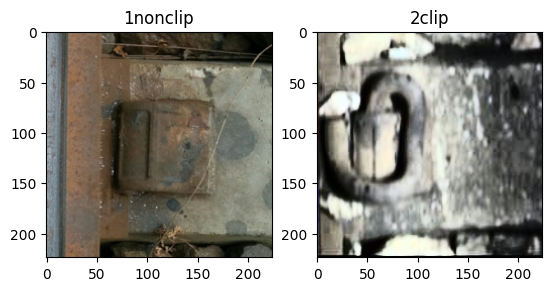

image size (224, 224, 3)


In [ ]:
nonClipImage, nonClipClassName = getImageFromDataset(fastenerTrainDataset, 4)
clipExistImage, clipExistClassName = getImageFromDataset(fastenerTrainDataset, 700)

_, figure = plt.subplots(1,2)

figure[0].imshow(nonClipImage)
figure[0].title.set_text(nonClipClassName)

figure[1].imshow(clipExistImage)
figure[1].title.set_text(clipExistClassName)
plt.show()

print('image size', nonClipImage.shape)

## 3.4 Define simple CNN network for fastener classification based on VGG-8.
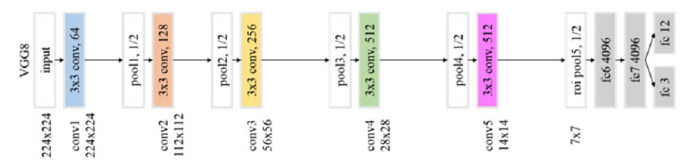


In [ ]:
### Build simple CNN ###
class simpleFastenerNet(nn.Module):
  def __init__(self):
    super(simpleFastenerNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))
    x = self.pool5(F.relu(self.conv5(x))) # 512x7x7


    x = x.view(-1, 512*7*7)

    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x


## 3.5 Construct the model, optimizer and loss function

In [ ]:
net = simpleFastenerNet()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(fastenerTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(fastenerTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3.6 Train the model

In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader))
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader))
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader,
                                                                    net,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=10)

Overall Training Progress::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

## 3.7 Find the confusion matrix and calculate TP, TN, FP, and FN

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

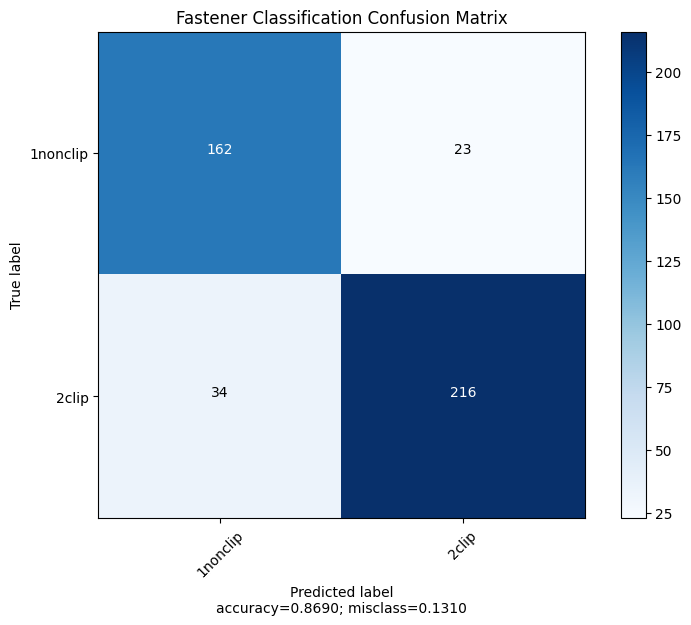

TP:162 TN:23 FP:34 FN:216


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = fastenerTrainDataset.classes,
                      title        = "Fastener Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

In [ ]:
#### Calculcate  Specificity, Sensitivity ###
sensitivity = tp / (tp+fn)
specificity = tn / (fp+tn)

## 3.8 Show Classification Results

In [ ]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

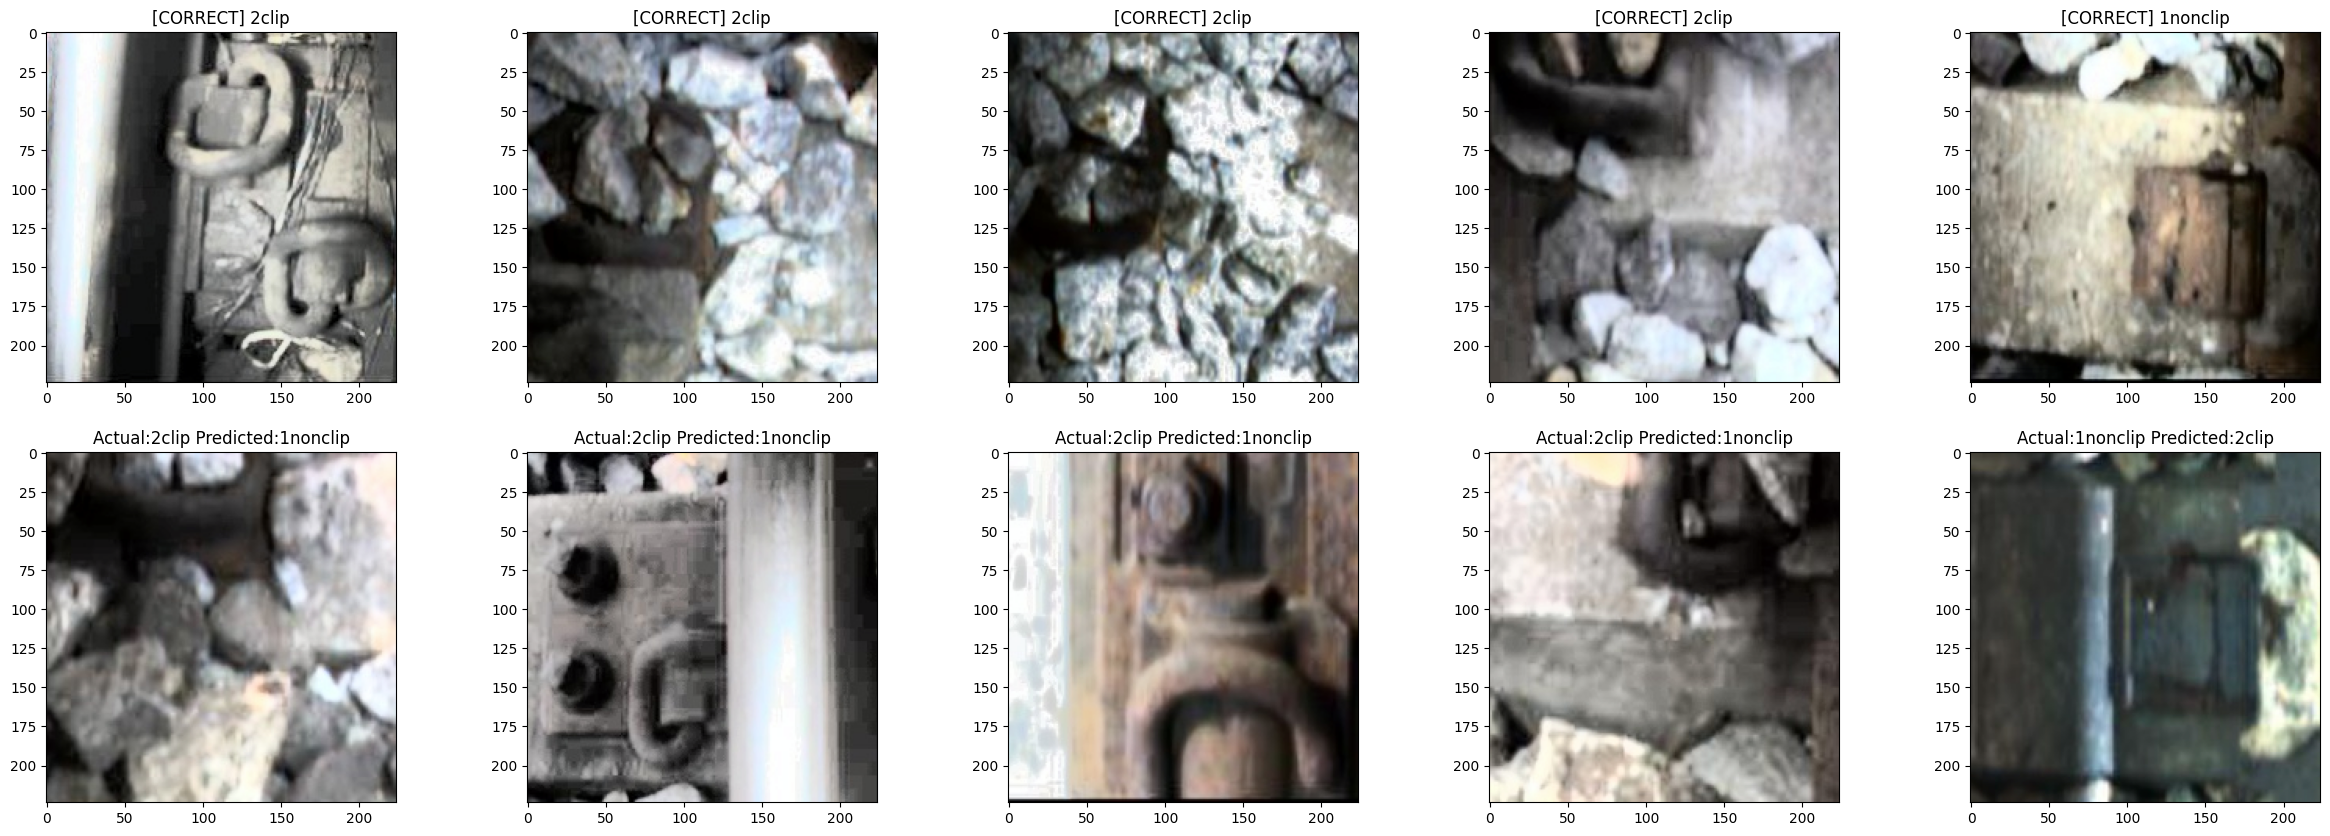

In [ ]:
showRandomSamples(allLabels,bestPredicted,fastenerTestDataset,sampleNum=5)

## 3.9 Transfer learning from pretrained model

Available pretrained models in PyTorch : https://pytorch.org/vision/stable/models.html

In [ ]:
pretrainNet = models.resnet34(pretrained=True)
# or you can use this
#num_ftrs = pretrainNet.fc.in_features
#pretrainNet.fc = nn.Linear(num_ftrs, 2)
# instead of figuring out the dimension from previous layer
pretrainNet.fc = nn.Linear(512, 2)
pretrainNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrainNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(fastenerTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(fastenerTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader,
                                                                    pretrainNet,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=10)

Overall Training Progress::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

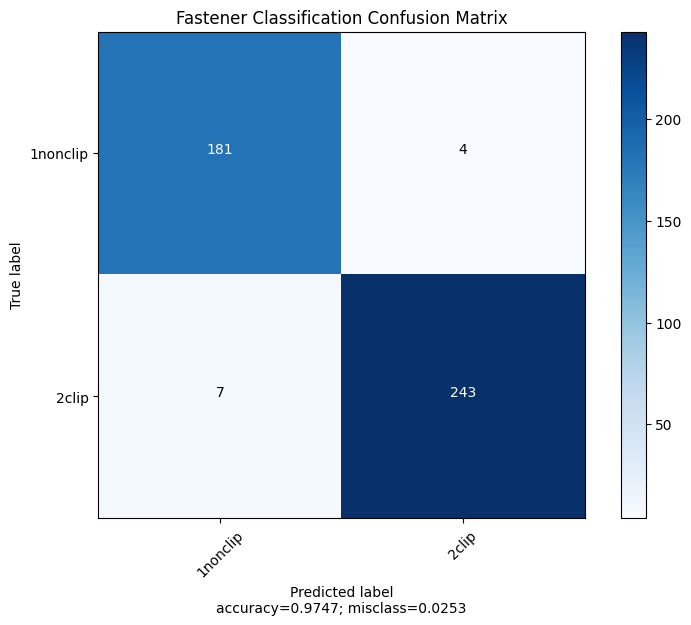

TP:181 TN:4 FP:7 FN:243


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = fastenerTrainDataset.classes,
                      title        = "Fastener Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

# 4.Exercise on dog breed classification.

In this exercise you will perform dog breed classification on images from https://www.kaggle.com/datasets/abhinavkrjha/dog-breed-classification

You goal is to use pytorch to read the dataset and train a CNN of your choice. Since the data is small, you should use transfer learning to get the best results.

The kaggle also comes with a Keras version of the task (https://www.kaggle.com/code/stpeteishii/dog-breed-classify-densenet201). You can use this as a reference for data loading. However, you should do this excercise using pytorch.

You might also look into data augmentation https://pytorch.org/docs/stable/torchvision/transforms.html to get the best results.

To easily download data from kaggle you should create a kaggle account. Generate an API key and upload it to colab.



In [1]:
! pip install -q kaggle

In [2]:
#Upload kaggle API key file
#from google.colab import files
#uploaded = files.upload()

import kagglehub
# Download latest version
path = kagglehub.dataset_download("abhinavkrjha/dog-breed-classification")
print("Path to dataset files:", path)

!mkdir '/root/.kaggle'
!cp 'kaggle.json' '/root/.kaggle/.'
!chmod 600 '/root/.kaggle/kaggle.json'

100%|██████████| 112M/112M [00:01<00:00, 76.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhinavkrjha/dog-breed-classification/versions/1
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d abhinavkrjha/dog-breed-classification

Dataset URL: https://www.kaggle.com/datasets/abhinavkrjha/dog-breed-classification
License(s): copyright-authors
 97% 109M/112M [00:00<00:00, 140MB/s] 
100% 112M/112M [00:00<00:00, 159MB/s]


In [4]:
!unzip dog-breed-classification.zip -d ./dog-breed-classification

Archive:  dog-breed-classification.zip
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_1.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_10.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_11.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_12.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_13.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_14.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_15.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_16.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_17.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_18.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_19.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_2.jpg  
  inflating: ./dog-breed-classification/Affenhuahua dog/Image_20.jpg  
  inflating: ./dog-breed-classification/

In [5]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# กำหนด path ของข้อมูล
data_dir = 'dog-breed-classification'
output_dir = 'dog-breed'

# สร้างโฟลเดอร์ train และ test
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# ดึงชื่อโฟลเดอร์ (ชื่อสายพันธุ์)
breed_names = os.listdir(data_dir)
breed_names = [breed for breed in breed_names if os.path.isdir(os.path.join(data_dir, breed))]

# เริ่มแยกข้อมูล
for breed in breed_names:
    breed_folder = os.path.join(data_dir, breed)
    images = os.listdir(breed_folder)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # แบ่งข้อมูล train และ test (80% train, 20% test)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=44)

    # สร้างโฟลเดอร์ย่อยตามชื่อสายพันธุ์ใน train และ test
    breed_train_dir = os.path.join(train_dir, breed)
    breed_test_dir = os.path.join(test_dir, breed)
    os.makedirs(breed_train_dir, exist_ok=True)
    os.makedirs(breed_test_dir, exist_ok=True)

    # คัดลอกไฟล์ไปยังโฟลเดอร์ train
    for img_name in train_images:
        src_path = os.path.join(breed_folder, img_name)
        dst_path = os.path.join(breed_train_dir, img_name)
        shutil.copy(src_path, dst_path)

    # คัดลอกไฟล์ไปยังโฟลเดอร์ test
    for img_name in test_images:
        src_path = os.path.join(breed_folder, img_name)
        dst_path = os.path.join(breed_test_dir, img_name)
        shutil.copy(src_path, dst_path)


In [7]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [8]:
### Dataloader for our dataset ###
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
TrainDataset = ImageFolder('dog-breed/train/', transform=transform)
TestDataset = ImageFolder('dog-breed/test/', transform=transform)

print('Total train set images :', len(TrainDataset))
print('Total test set images :', len(TestDataset))

Total train set images : 554
Total test set images : 140


In [29]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetDogClassifier(nn.Module):
    def __init__(self, num_classes=14):
        super(ResNetDogClassifier, self).__init__()
        # โหลด ResNet-18 pretrained model
        self.resnet = models.resnet18(pretrained=True)

        # ปรับแต่ง fully connected layer ให้รองรับ 14 classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [30]:
# สร้างโมเดล
net = ResNetDogClassifier(num_classes=14)

# ส่งโมเดลไปยัง GPU (ถ้ามี)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Learning Rate Scheduler (ลดค่า learning rate เมื่อ loss ไม่ลด)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

TrainDatasetLoader = DataLoader(TrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
TestDatasetLoader = DataLoader(TestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in 

In [31]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader))
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader))
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet


In [32]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(TrainDatasetLoader, TestDatasetLoader,
                                                                    net,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=10)

Overall Training Progress::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

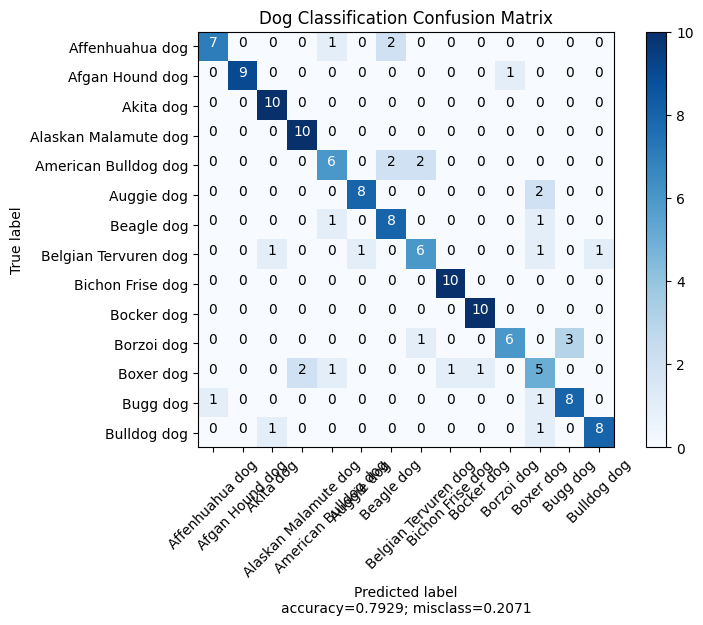

In [34]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = TrainDataset.classes,
                      title        = "Dog Classification Confusion Matrix")


In [35]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

In [36]:
showRandomSamples(allLabels,bestPredicted,TestDataset,sampleNum=5)

Output hidden; open in https://colab.research.google.com to view.